# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 


## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [13]:
#Прологарифмируем целевую переменную price, чтобы сделать её распределение более походим на нормальное
train.price = train.price.apply(lambda x: np.log(np.log(x)))

In [14]:
#Прологарифмируем числовые признаки
#train['mileage']=np.log(np.log(train['mileage']))


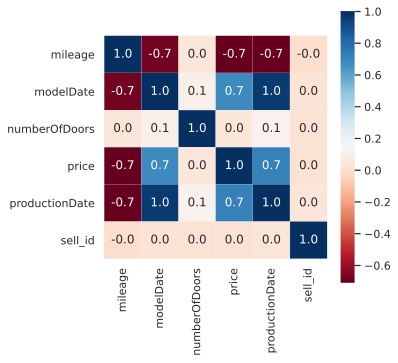

In [15]:
#Построим  корреляционную матрицу:
sns.set(font_scale=1)
plt.subplots(figsize=(5, 5))
sns.heatmap(train.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [16]:
train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [17]:
#Преобразуем в числовые данные признак engineDisplacement:
#train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: '2.0 LTR' if x=='undefined LTR' else x)
#train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: float(x[0:3]))

In [18]:
#Преобразуем в числовые данные признак enginePower:
#train['enginePower'] = train['enginePower'].apply(lambda x: int(x[:-4]))
#train['enginePower'] = np.log(np.log(train['enginePower']))

In [19]:
#sns.set(font_scale=1)
#plt.subplots(figsize=(5, 5))
#sns.heatmap(train.corr(), square=True,
           #   annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [20]:
#train.columns

In [21]:
#def vladenie(x):
  #  if x=='1\xa0владелец':
  #     return 1
   # if x =='2\xa0владельца':
   #     return 2
   # if x =='3 или более':
    #    return 3

In [22]:
#train.Владельцы = train.Владельцы.apply(vladenie)

In [23]:
#train.Владельцы.value_counts()

In [24]:
#sns.set(font_scale=1)
#plt.subplots(figsize=(5, 5))
#sns.heatmap(train.corr(), square=True,
          #    annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Посмотрим, как выглядят распределения числовых признаков:

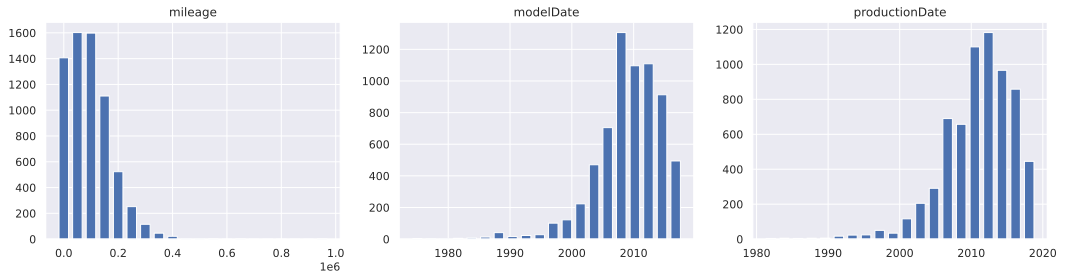

In [25]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [26]:
train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [27]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль'] 

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate',
       'enginePower','engineDisplacement','productionDate', 'Владельцы'] 


In [28]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


#  My Preproc

In [29]:
#Прологарифмируем числовые признаки
data['mileage']=np.log(data['mileage'])

In [30]:
#Преобразуем в числовые данные признак engineDisplacement:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x=='undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: float(x[0:3]))

In [31]:
#Преобразуем в числовые данные признак enginePower:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4]))
data['enginePower'] = np.log(np.log(data['enginePower']))

In [32]:
#Преобразуем признак владельцы в числовые данные:
def vladenie(x):
    if x=='1\xa0владелец':
        return 1
    if x =='2\xa0владельца':
        return 2
    if x =='3 или более':
        return 3

In [33]:
data['Владельцы']=data['Владельцы'].apply(vladenie)

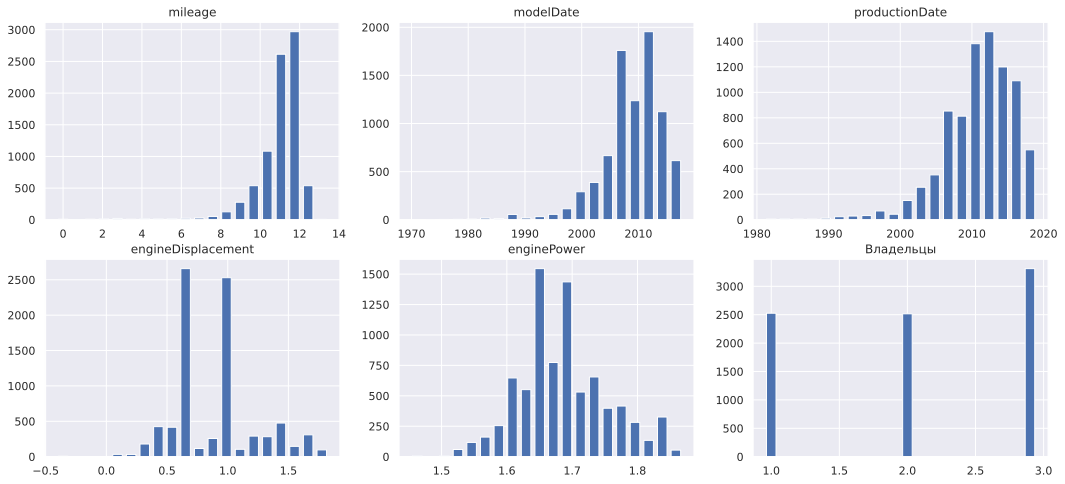

In [34]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'modelDate': data['modelDate'].dropna(),
    'productionDate': data['productionDate'].dropna(),
    'engineDisplacement': np.log(data['engineDisplacement']).dropna(),
    'enginePower': data['enginePower'].dropna(),
    'Владельцы': data['Владельцы'].dropna()
})

In [35]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True) ####!!!
    
    return df_output

In [36]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владельцы,sample,price,bodyType_0,bodyType_1,...,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.220339,0.581124,0.838231,0.895833,0.868421,0.0,1,2.658807,0,1,...,0,0,0,0,1,0,0,1,1,0
4273,0.220339,0.581124,0.775535,0.875000,0.894737,0.0,1,2.704505,0,1,...,0,0,0,0,1,0,0,1,1,0
3362,0.813559,0.933380,0.790060,0.875000,0.868421,1.0,1,2.717160,0,0,...,0,0,0,0,1,0,0,1,1,0
2794,0.389831,0.581124,0.849485,0.833333,0.763158,1.0,1,2.674400,0,0,...,0,0,1,0,1,0,0,1,1,0
5378,0.220339,0.529671,0.862198,0.875000,0.868421,1.0,1,2.643780,0,0,...,0,0,0,0,1,0,0,1,1,0
5902,0.559322,0.916884,0.807309,0.854167,0.815789,0.0,1,2.710666,0,0,...,0,0,0,0,1,0,0,1,1,0
1454,0.389831,0.694815,0.787059,0.854167,0.868421,0.5,0,0.000000,0,0,...,0,0,0,0,1,0,0,1,1,0
2476,0.305085,0.529671,0.873217,0.750000,0.684211,1.0,1,2.599636,0,0,...,0,0,0,1,0,1,0,0,1,0
743,0.152542,0.226411,0.846530,0.750000,0.736842,1.0,0,0.000000,0,0,...,0,0,0,0,1,1,0,0,1,0
1168,0.813559,0.905872,0.759384,0.854167,0.842105,1.0,0,0.000000,0,1,...,0,0,0,0,1,0,0,1,1,0


In [37]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 1161 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(1), uint8(1153)
memory usage: 9.7 MB


## Split data

In [38]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 1160 entries, engineDisplacement to Руль_1
dtypes: float64(7), uint8(1153)
memory usage: 1.9 MB


# Model 2: CatBoostRegressor

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [41]:
model = CatBoostRegressor(iterations = 7000,
                          depth=10,
                          learning_rate = 0.020953,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0157965	test: 0.0158129	best: 0.0158129 (0)	total: 104ms	remaining: 12m 11s
100:	learn: 0.0047499	test: 0.0047121	best: 0.0047121 (100)	total: 4.58s	remaining: 5m 12s
200:	learn: 0.0035575	test: 0.0036030	best: 0.0036030 (200)	total: 8.53s	remaining: 4m 48s
300:	learn: 0.0033053	test: 0.0033999	best: 0.0033999 (300)	total: 12.2s	remaining: 4m 32s
400:	learn: 0.0031538	test: 0.0032962	best: 0.0032962 (400)	total: 16.6s	remaining: 4m 32s
500:	learn: 0.0030521	test: 0.0032253	best: 0.0032253 (500)	total: 20.4s	remaining: 4m 24s
600:	learn: 0.0029659	test: 0.0031757	best: 0.0031757 (599)	total: 24.1s	remaining: 4m 17s
700:	learn: 0.0028861	test: 0.0031346	best: 0.0031346 (700)	total: 29s	remaining: 4m 20s
800:	learn: 0.0027961	test: 0.0030945	best: 0.0030944 (798)	total: 32.7s	remaining: 4m 13s
900:	learn: 0.0027305	test: 0.0030656	best: 0.0030652 (893)	total: 37.3s	remaining: 4m 12s
1000:	learn: 0.0026662	test: 0.0030396	best: 0.0030394 (997)	total: 41.6s	remaining: 4m 9s
1100

In [42]:
#Выполним предсказание модели catboost
test_predict_catboost = model.predict(X_test)

In [43]:
#Возьмём обратную логарифму функцию - экспоненту (дважды), чтобы преобразовать тестовые данные в нормальный вид
abc = np.exp(np.exp(y_test))

In [44]:
#Cделаем то же самое для предсказаний
abc2 = np.exp(np.exp(test_predict_catboost))

In [45]:
abc2

array([ 576581.44110966,  949662.81642047, 1209796.70834274, ...,
        620383.56007467,  985142.49191378,  974743.3140176 ])

In [46]:
print(f"TEST mape: {(mape((abc), abc2))*100:0.2f}%")

TEST mape: 10.99%


In [47]:
#logprice + logmileage = 11,65%
#loglogprice + logmileage + drop(modeldate) = 11,78%
#loglogprice TEST mape: 11.04% (с dropom vehicleConfiguration, а также logmileage, обработкой л.с., displaycement, Владельцы)
#loglogprice TEST mape: 11.02% (без дропа vehicleConfiguration)

### Submission

In [48]:
sub_predict_catboost = model.predict(X_sub)


In [49]:
sub_predict_catboost=np.exp(np.exp(sub_predict_catboost))

In [50]:
sub_predict_catboost

array([ 636858.96358895, 2455991.42193338,  669169.68189501, ...,
       1539093.22366963, 1112989.5319902 , 1075717.27242839])

In [51]:
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

Для нейронных сетей не будем логарифмировать целевую переменную price, т.к. в результате эксперимента NN работает лучше без этого

In [52]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    #Прологарифмируем modelDate и productionDate для достижения более нормального распределения данных
    df_output = df_input.copy()
    df_output['modelDate'] = np.log(2030 - df_output['modelDate'])
    df_output['productionDate'] = np.log(2030 - df_output['productionDate'])
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True) ####!!!
    
    return df_output

In [53]:
# Запускаем и проверяем, что получилось
df_preproc_for_NN = preproc_data(data)
df_preproc_for_NN.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владельцы,sample,price,bodyType_0,bodyType_1,...,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.220339,0.490976,0.891384,0.412676,0.502645,0.0,1,2.591777,0,0,...,0,0,1,0,1,0,0,1,1,0
6421,0.220339,0.357085,0.866257,0.384979,0.374717,0.5,1,2.597480,0,1,...,0,0,0,0,1,1,0,0,1,0
7645,0.186441,0.387779,0.829621,0.439141,0.472989,0.5,1,2.587991,0,0,...,1,0,0,0,1,0,1,0,1,0
7222,0.220339,0.581124,0.757345,0.184655,0.214503,0.5,1,2.679718,0,1,...,0,0,0,0,1,0,0,1,1,0
4604,0.389831,0.603558,0.852324,0.384979,0.374717,0.5,1,2.644056,0,0,...,0,0,0,0,1,0,0,1,1,0
5140,0.101695,0.357085,0.673618,0.051804,0.060761,0.0,1,2.671131,0,0,...,0,0,1,0,1,0,1,0,1,0
728,0.186441,0.387779,0.866900,0.439141,0.409185,1.0,0,0.000000,0,0,...,1,0,0,0,1,0,1,0,1,0
7029,0.305085,0.529671,0.830379,0.556255,0.558115,0.0,1,2.596930,0,0,...,0,0,0,0,1,1,0,0,1,0
1997,0.389831,0.676142,0.893054,0.439141,0.472989,1.0,1,2.623585,0,1,...,0,0,0,0,1,0,0,1,1,0
3433,0.220339,0.515090,0.867353,0.325393,0.374717,1.0,1,2.617321,0,0,...,0,0,1,0,1,0,0,1,1,0


In [54]:
# Теперь выделим тестовую часть
train_data1 = df_preproc_for_NN.query('sample == 1').drop(['sample'], axis=1)
test_data1 = df_preproc_for_NN.query('sample == 0').drop(['sample'], axis=1)

y_1 = train_data1.price.values     # наш таргет
X_1 = train_data1.drop(['price'], axis=1)
X_sub1 = test_data1.drop(['price'], axis=1)

In [55]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [56]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train1.shape[1], activation="relu")) #1024
model.add(L.Dropout(0.75)) #0.75
model.add(L.Dense(512, activation="relu")) #512
model.add(L.Dropout(0.6)) #0.6
model.add(L.Dense(1, activation="linear"))

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1187840   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,713,153
Trainable params: 1,713,153
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [59]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [60]:
#Возвратим целевые переменные в исходный вид
y_train1=np.exp(np.exp(y_train1))
y_test1=np.exp(np.exp(y_test1))

In [61]:
history = model.fit(X_train1, y_train1,
                    batch_size=512, #512
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test1, y_test1),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

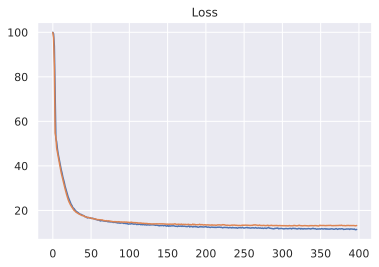

In [62]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [63]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [64]:
test_predict_nn1 = model.predict(X_test1)
print(f"TEST mape: {(mape((y_test1), test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 13.23%


In [65]:
#Посмотрим, какой mape даст сочетание catboost и nn1:
print(f"TEST mape: {(mape((y_test1), (test_predict_nn1[:,0]+abc2)/2))*100:0.2f}%")

TEST mape: 11.09%


In [66]:
#tf.keras.backend.clear_session()

In [67]:
sub_predict_nn1 = model.predict(X_sub1)

In [68]:
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [69]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.3 MB/s 
     |████████████████████████████████| 8.2 MB 6.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [70]:
#Избавимся от лишних символов в описании методом ручного просмотра tokenize.word_index:
data.description = data.description.apply(lambda x: str(x).replace('[',' ').replace(']',' ').replace("'",' ').replace('•',' ').replace(',',' ').replace('―',' ').replace('–',' ').replace('«',' ').replace('»',' ').replace('✔',' ').replace('►',' ').replace('°',' ').replace('u',' ').replace('d',' ').replace('№',' ').replace('″',' ').replace('🏻',' ').replace('👮',' ').replace('♂️',' ').replace('❌',' ').replace('🤫','').replace('сыюъшаютър',' ').replace('твюь',' ').replace('яаш',' ').replace('ваюурэшш',' ').replace('ьхбвр',' ').replace('👋',' ').replace('👍',' ').replace('☝️',' ').replace('🔥',' ').replace('👋',' ').replace('💡',' ').replace('“',' ').replace('”',' ').replace('’',' ').replace('∙',' ').replace('\n',' ').replace('-',' ').replace('·',' ').replace('☛',' ').replace('₽',' ').replace('▼',' ').replace('f08',' ').replace('✪',' ').replace('✅',' ').replace('200b',' ').replace('☑️',' ').replace('…',' ').replace('。',' ').replace('⭐️',' ').replace('●',' ').replace('™',' ').replace('😉',' ').replace('☝',' ').replace('😅',' ').replace('▶',' ').replace('ö',' ').replace('🎁',' ').replace('😁',' ').replace('💁',' ').replace('🤷',' ').replace('☆',' ').replace('´',' ').replace('®️',' ').replace('❤️',' ').replace('²',' ').replace('202a',' ').replace('202c',' ').replace('😊',' ').replace('🎶',' ').replace('💆',' ').replace('♀️',' ').replace('🇯🇵',' ').replace('🍋',' ').replace('🤙',' ').replace('😇',' ').replace('º',' ').replace('🚘',' ').replace('✈️',' ').replace('🤗',' ').replace('®',' ').replace('❗',' ').replace('‼️',' ').replace('😀',' ').replace('ß',' ').replace('✌',' ').replace('🏽',' ').replace('😂',' ').replace('✨',' ').replace('🏼',' ').replace('👌',' ').replace('⬇️',' ').replace('💥',' ').replace('🧐',' ').replace('💪',' ').replace('。',' ').replace('😃',' ').replace('⚡',' ').replace('🚀',' ').replace('♠️',' ').replace('🎖️',' ').replace('💎',' ').replace('🔸',' ').replace('⭕️',' ').replace('🎯',' ').replace('🧟',' ').replace('😎',' ').replace('č',' ').replace('☎',' ').replace('⛽️',' ').replace('🙂',' ').replace('👺',' ').replace('✌️',' ').replace('🔝',' ').replace('😒',' ').replace('😉',' ').replace('🏆',' ').replace('🏝',' ').replace('🚨',' ').replace('🤛',' ').replace('👌',' ').replace('😁',' ').replace('🔕͟',' '))

In [71]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+" #"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split(): 
        token = token.strip()
        token = morph.normal_forms(token)[0]
        if token and token not in stopwords_ru:
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None


### За счёт данной функции:
    1).избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов;
    2).разобьем пост на токены;
    3).проведем лемматизацияю, получив нормальную (начальную) форму слова;
    4).удалим стоп-слова.

In [72]:
data.description = data.description.apply(lemmatize)

In [73]:
#Возвратим формат данных обратно в строчное представление
data.description = data.description.apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').replace('•','').replace(',',''))

In [74]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256 #256

In [75]:
# split данных
text_train = data.description.iloc[X_train1.index]
text_test = data.description.iloc[X_test1.index]
text_sub = data.description.iloc[X_sub1.index]

In [76]:
text_train[6323]

'ода комплект колесо лето новый вложение никакой делать нужно прям крашеный деталь всё подробный встреча посредник мимо машина пользование каждый день причина продажа желание приобрести авто большой торг возможный встреча смс телефон конкретно капот п товарищ предложение свой цена цель перепродажа учёт поставить огромный просьба предлагать ваш условие интересный машина продаваться условие стоить ровно столько сколько выставить торг строго капот дилер припереть проверять пока объявление весить машина продаваться сколько продаваться барабан ездить каждый день'

### Tokenizer

In [77]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.18 s, sys: 1.75 ms, total: 1.18 s
Wall time: 1.19 s


In [78]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'всё': 4,
 'задний': 5,
 'салон': 6,
 'сидение': 7,
 'год': 8,
 'состояние': 9,
 'передний': 10,
 'машина': 11,
 'диск': 12,
 'комплект': 13,
 'дилер': 14,
 'новый': 15,
 'официальный': 16,
 'ваш': 17,
 'кредит': 18,
 'фара': 19,
 'авто': 20,
 'гарантия': 21,
 'руль': 22,
 'пакет': 23,
 'колесо': 24,
 'безопасность': 25,
 'комплектация': 26,
 'птс': 27,
 'обмен': 28,
 'контроль': 29,
 'зеркало': 30,
 'проверка': 31,
 'покупка': 32,
 'весь': 33,
 'продажа': 34,
 'водитель': 35,
 'полный': 36,
 'шина': 37,
 'датчик': 38,
 'км': 39,
 'пассажир': 40,
 'отличный': 41,
 'двигатель': 42,
 'резина': 43,
 'условие': 44,
 'владелец': 45,
 'ключ': 46,
 'хороший': 47,
 'кузов': 48,
 'подушка': 49,
 'подогрев': 50,
 'обогрев': 51,
 'технический': 52,
 'любой': 53,
 'обслуживание': 54,
 'юридический': 55,
 'оригинал': 56,
 'стекло': 57,
 'масло': 58,
 'м': 59,
 'торг': 60,
 'дверь': 61,
 'замена': 62,
 'чёрный': 63,
 'пройти': 64,
 'рулевой': 65,
 'эле

In [79]:
#Тот самый ручной перебор
for i in tokenize.word_index:
    print(i)

автомобиль
система
пробег
всё
задний
салон
сидение
год
состояние
передний
машина
диск
комплект
дилер
новый
официальный
ваш
кредит
фара
авто
гарантия
руль
пакет
колесо
безопасность
комплектация
птс
обмен
контроль
зеркало
проверка
покупка
весь
продажа
водитель
полный
шина
датчик
км
пассажир
отличный
двигатель
резина
условие
владелец
ключ
хороший
кузов
подушка
подогрев
обогрев
технический
любой
обслуживание
юридический
оригинал
стекло
масло
м
торг
дверь
замена
чёрный
пройти
рулевой
электропривод
оригинальный
наш
купить
климат
кожа
сервисный
дтп
дополнительный
рольф
это
зимний
автоматический
свет
проверить
каждый
документ
функция
кожаный
продавать
центр
коробка
часть
идеальный
управление
цвет
день
работать
память
подготовка
программа
защита
камера
полностью
чистота
вид
свой
центральный
багажник
телефон
очень
спортивный
кредитование
боковой
родный
сделать
л
звонить
электрорегулировка
компания
время
возможный
заменить
отделка
история
тормозной
комплексный
наличие
обивка
г
регулировка
адаптив

In [80]:
len(tokenize.word_index)
#14250

13623

In [81]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.88 s, sys: 4.18 ms, total: 1.88 s
Wall time: 1.91 s


In [82]:
# вот так теперь выглядит наш текст
print(text_sub.iloc[1470])
print(text_train_sequences[6])

автомобиль отличный состояние птс оригинал провести комплексный диагностика проверка юридический чистота автомобиль автомобиль полностью защитный плёнка очень богатый комплектация ауди центр варшавка официальный дилер ауди входящий состав группа компания автоспеццентр основать всё автомобиль проходить комплексный технический проверка гарантия юридический чистота дополнительный выгода обмен ваш автомобиль данный автомобиль приобрести кредит льготный условие ставка первоначальный взнос покупка автомобиль наличный каско подарок подробность уточнять менеджер продажа
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0

### RNN NLP

In [83]:
#tf.keras.backend.clear_session()

In [84]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1 , MAX_SEQUENCE_LENGTH,)) #len(tokenize.word_index)+1
model_nlp.add(L.LSTM (256, return_sequences=True)) #256
model_nlp.add(L.Dropout(0.5)) #0.5
model_nlp.add(L.LSTM (128,)) #LSTM  #128
model_nlp.add(L.Dropout(0.25)) #0.25
model_nlp.add(L.Dense(64, activation="relu")) #64
model_nlp.add(L.Dropout(0.25))

### MLP

In [85]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train1.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [86]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [87]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3487744     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [88]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [89]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [90]:
text_train_sequences

array([[   0,    0,    0, ..., 1236,  518, 2253],
       [   0,    0,    0, ...,  709,   32,   60],
       [   0,    0,    0, ...,  204,  145,    1],
       ...,
       [   0,    0,    0, ..., 1298,   15,   45],
       [   0,    0,    0, ...,   43,   67,   12],
       [   0,    0,    0, ...,   13,  758,  208]], dtype=int32)

In [91]:
history = model.fit([text_train_sequences, X_train1], y_train1, #text_train_sequences
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test1], y_test1), #text_test_sequences
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 347ms/step - loss: 99.9927 - MAPE: 99.9927 - val_loss: 99.9103 - val_MAPE: 99.9103
Epoch 2/500
12/12 [==============================] - 3s 284ms/step - loss: 99.0815 - MAPE: 99.0815 - val_loss: 95.6046 - val_MAPE: 95.6046
Epoch 3/500
12/12 [==============================] - 3s 250ms/step - loss: 84.6687 - MAPE: 84.6687 - val_loss: 57.6600 - val_MAPE: 57.6600
Epoch 4/500
12/12 [==============================] - 3s 234ms/step - loss: 54.7372 - MAPE: 54.7372 - val_loss: 51.5418 - val_MAPE: 51.5418
Epoch 5/500
12/12 [==============================] - 3s 251ms/step - loss: 49.0105 - MAPE: 49.0105 - val_loss: 47.4878 - val_MAPE: 47.4878
Epoch 6/500
12/12 [==============================] - 3s 224ms/step - loss: 45.6302 - MAPE: 45.6302 - val_loss: 43.7113 - val_MAPE: 43.7113
Epoch 7/500
12/12 [==============================] - 3s 227ms/step - loss: 42.1995 - MAPE: 42.1995 - val_loss: 40.4336 - val_MAPE: 40.4336
Epoch 8/500
12/12 [========

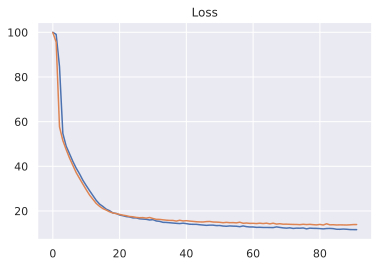

In [92]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [93]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [94]:
test_predict_nn2 = model.predict([text_test_sequences, X_test1])
print(f"TEST mape: {(mape(y_test1, test_predict_nn2[:,0]))*100:0.2f}%") 

TEST mape: 13.92%


In [95]:
#Посмотрим, какой mape даст сочетание catboost и nn2:
print(f"TEST mape: {(mape((y_test1), (test_predict_nn2[:,0]+abc2)/2))*100:0.2f}%")

TEST mape: 11.48%


In [96]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub1])

In [97]:
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

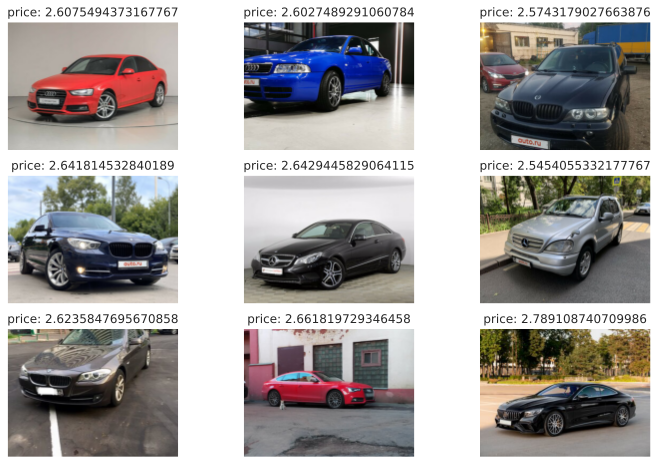

In [98]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [99]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train1.index)
images_test = get_image_array(X_test1.index)
images_sub = get_image_array(X_sub1.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

Здесь я попробовал "подкрутить" все параметры аугментации в большую сторону

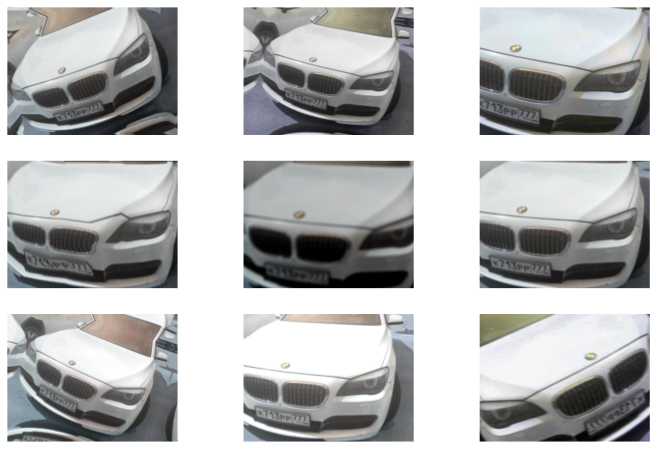

In [100]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.3),    #0.2
    OneOf([
        MotionBlur(p=0.3), #0.1
        MedianBlur(blur_limit=5, p=0.3), #3 , 0.1 
        Blur(blur_limit=5, p=0.3), #3 , 0.1
    ], p=0.3), #0.2
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.4, rotate_limit=25, p=3), #(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1)
    OneOf([
        OpticalDistortion(p=0.4), #0.3
        GridDistortion(p=0.2), #0.1
        IAAPiecewiseAffine(p=0.4),#0.3
    ], p=0.3), #0.2
    OneOf([
        CLAHE(clip_limit=5), #2
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.4), #0.3
    HueSaturationValue(p=0.4), #0.3
], p=3) #1

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [101]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [102]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [103]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train1, data.description.iloc[X_train1.index], y_train1  #текст x_train  data.description.iloc[X_train1.index]
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test1, data.description.iloc[X_test1.index], y_test1   # x_test вместо data.description data.description.iloc[X_test1.index]
    )).map(tf_process_val_dataset_element)

y_sub1 = np.zeros(len(X_sub1))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub1, data.description.iloc[X_sub1.index], y_sub1
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [104]:
#Изменил модель на EfficientNetB4
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))#EfficientNetB3
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

71688192/71686520 [==============================] - 1s 0us/step


In [105]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X_1.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [106]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [107]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [108]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [109]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [110]:
history = model.fit(train_dataset.batch(30),
                    epochs=35, #100 Поменял в результате эксперимента количество эпох на наиболее оптимальное
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/35
190/190 [==============================] - 161s 847ms/step - loss: 55.8741 - MAPE: 55.8741 - val_loss: 69.0393 - val_MAPE: 69.0393
Epoch 2/35
190/190 [==============================] - 155s 817ms/step - loss: 29.6368 - MAPE: 29.6368 - val_loss: 23.6818 - val_MAPE: 23.6818
Epoch 3/35
190/190 [==============================] - 159s 834ms/step - loss: 21.2847 - MAPE: 21.2847 - val_loss: 20.0485 - val_MAPE: 20.0485
Epoch 4/35
190/190 [==============================] - 157s 824ms/step - loss: 18.2101 - MAPE: 18.2101 - val_loss: 17.2483 - val_MAPE: 17.2483
Epoch 5/35
190/190 [==============================] - 158s 830ms/step - loss: 16.7581 - MAPE: 16.7581 - val_loss: 16.5474 - val_MAPE: 16.5474
Epoch 6/35
190/190 [==============================] - 156s 819ms/step - loss: 15.7006 - MAPE: 15.7006 - val_loss: 16.1733 - val_MAPE: 16.1733
Epoch 7/35
190/190 [==============================] - 157s 829ms/step - loss: 15.0639 - MAPE: 15.0639 - val_loss: 16.2848 - val_MAPE: 16.2848
Epoch 

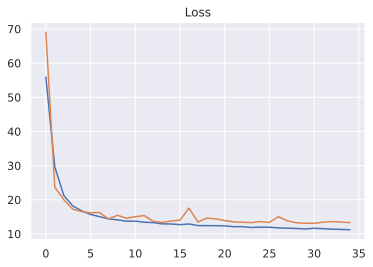

In [111]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [112]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [113]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test1, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.29%


In [114]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))

In [115]:
sub_predict_nn3

array([[ 404545.44],
       [2247689.8 ],
       [ 570761.  ],
       ...,
       [1459784.2 ],
       [1136496.1 ],
       [1153399.2 ]], dtype=float32)

In [116]:
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [117]:
blend_predict = (abc2 + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test1, blend_predict))*100:0.2f}%")

TEST mape: 11.14%


In [118]:
#Округлил предсказание и привел его в надлежащий для демонстрации вид с помощью np.floor
blend_predict5 = np.floor((abc2 + test_predict_nn3[:,0]) / 2/10000)*10000
print(f"TEST mape: {(mape(y_test1, blend_predict5))*100:0.2f}%")

TEST mape: 11.15%


In [119]:
blend_predict5

array([ 580000.,  860000., 1290000., ...,  650000.,  960000., 1030000.])

In [120]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [121]:
blend_sub_predictt = np.floor((sub_predict_catboost + sub_predict_nn3[:,0]) / 2/10000)*10000
sample_submission['price'] = blend_sub_predictt
sample_submission.to_csv('blend_submissionn.csv', index=False)

# Model Bonus: проброс признака (в своей работе не использовал)

In [122]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [123]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [124]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [125]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 1159)]       0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          593920      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [126]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [127]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 24ms/step - loss: 61.2328 - MAPE: 61.2328 - val_loss: 34.5331 - val_MAPE: 34.5331
Epoch 2/500
12/12 [==============================] - 0s 11ms/step - loss: 25.9107 - MAPE: 25.9107 - val_loss: 20.9352 - val_MAPE: 20.9352
Epoch 3/500
12/12 [==============================] - 0s 11ms/step - loss: 16.1171 - MAPE: 16.1171 - val_loss: 5.3644 - val_MAPE: 5.3644
Epoch 4/500
12/12 [==============================] - 0s 11ms/step - loss: 9.3147 - MAPE: 9.3147 - val_loss: 1.7555 - val_MAPE: 1.7555
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 3.4369 - MAPE: 3.4369 - val_loss: 1.7935 - val_MAPE: 1.7935
Epoch 6/500
12/12 [==============================] - 0s 11ms/step - loss: 1.7628 - MAPE: 1.7628 - val_loss: 1.5870 - val_MAPE: 1.5870
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 1.6946 - MAPE: 1.6946 - val_loss: 1.4576 - val_MAPE: 1.4576
Epoch 8/500
12/12 [==============================] -

In [128]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 0.69%


In [129]:
# 